 # 1. Purpose of the project

This project will focus on data collected from stackoverflow. <br>
Using a DL model (BEART) I will try to predict if a question posted on the site is at risk of being closed. <br>
Questions that don't meet the stockoverfull standard are closed because they are irrelevant, poorly written, etc (about 6% of the questions posted). <br>

Main parts:
* Import libraries and load data from database
* Data exploration
* Data cleaning and preparation
* Building our custom BERT model
* Training
* Evaluate the model results
* Conclusions

 # 2. Import libraries and load data from database

### libraries

In [7]:
# libraries

# data manipulation
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import re
import os
from pathlib import Path  
import datetime
import seaborn as sn

# import nlp Tokenizer/tools
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import words
from nltk.stem import WordNetLemmatizer
nltk.download('omw-1.4')
from transformers import BertTokenizer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
from tqdm import tqdm
from transformers import BertModel,DistilBertModel
from transformers import AdamW

# Evaluation and data prep
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split

# setup
pd.set_option('display.max_colwidth', None) # want to see all info in a cell

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Loading data

In [8]:
# Loading and printing head
df_stock_over_raw = pd.read_csv("../input/predict-closed-questions-on-stack-overflow/train-sample.csv")

In [9]:
df_stock_over_raw[0:3]

,PostId,PostCreationDate,OwnerUserId,OwnerCreationDate,ReputationAtPostCreation,OwnerUndeletedAnswerCountAtPostTime,Title,BodyMarkdown,Tag1,Tag2,Tag3,Tag4,Tag5,PostClosedDate,OpenStatus
0,6046168,05/18/2011 14:14:05,543315,09/17/2010 10:15:06,1,2,For Mongodb is it better to reference an object or use a natural String key?,"I am building a corpus of indexed sentences in different languages. I have a collection of Languages which have both an ObjectId and the ISO code as a key. Is it better to use a reference to the Language collection or store a key like ""en"" or ""fr""?\r\n\r\nI suppose it's a compromise between:\r\n\r\n - ease of referencing the Language\r\n - object in that collection\r\n - speed in doing queries where the sentence has a certain language\r\n - the size of the data on disk\r\n\r\nAny best practices that I should know of?",mongodb,NaN,NaN,NaN,NaN,NaN,open
1,4873911,02/02/2011 11:30:10,465076,10/03/2010 09:30:58,192,24,How to insert schemalocation in a xml document via DOM,"i create a xml document with JAXP and search a way to insert the schemalocation.\r\nAt the moment my application produces:\r\n\r\n <?xml version=""1.0"" encoding=""UTF-8""?>\r\n <root>\r\n ...\r\n </root>\r\n\r\nBut i need:\r\n\r\n <?xml version=""1.0"" encoding=""UTF-8""?>\r\n <root xmlns=""namespaceURL"" \r\n xmlns:xs=""http://www.w3.org/2001/XMLSchema-instance""\r\n xs:schemaLocation=""namespaceURL pathToMySchema.xsd"">\r\n ...\r\n </root>\r\n\r\nMy code:\r\n\r\n StreamResult result = new StreamResult(writer);\r\n Document doc = getDocument();\r\n\r\n Transformer trans = transfac.newTransformer();\r\n trans.setOutputProperty(OutputKeys.INDENT, ""yes"");\r\n trans.setOutputProperty(OutputKeys.METHOD, ""xml"");\r\n trans.setOutputProperty(OutputKeys.VERSION, ""1.0"");\r\n trans.setOutputProperty(OutputKeys.ENCODING, ""UTF-8"");\r\n\r\n DOMSource source = new DOMSource(depl.getAsElement(doc));\r\n trans.transform(source, result);\r\n\r\n\r\nThanks for your time, \r\nKasten",dom,xsd,jaxp,NaN,NaN,NaN,open
2,3311559,07/22/2010 17:21:54,406143,07/22/2010 16:58:20,1,0,Too many lookup tables,"What are the adverse effects of having too many lookup tables in the database?\r\n\r\n I have to incorportate too many Enumerations, based on the applications. \r\n\r\nWhat would experts advice?",sql-server,database-design,enums,NaN,NaN,NaN,open


 # 3. Data exploration

### Lets take a look at the diffrent columns

In [10]:
df_stock_over_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140272 entries, 0 to 140271
Data columns (total 15 columns):
 #   Column                               Non-Null Count   Dtype 
---  ------                               --------------   ----- 
 0   PostId                               140272 non-null  int64 
 1   PostCreationDate                     140272 non-null  object
 2   OwnerUserId                          140272 non-null  int64 
 3   OwnerCreationDate                    140272 non-null  object
 4   ReputationAtPostCreation             140272 non-null  int64 
 5   OwnerUndeletedAnswerCountAtPostTime  140272 non-null  int64 
 6   Title                                140272 non-null  object
 7   BodyMarkdown                         140272 non-null  object
 8   Tag1                                 140262 non-null  object
 9   Tag2                                 113021 non-null  object
 10  Tag3                                 75914 non-null   object
 11  Tag4                      

We have 140,272 data points, lets see how many are closed vs open.

### Lets take a look at the ratio of diffrent status values

In [11]:
df_stock_over_raw.groupby(['OpenStatus']).count()['PostId']/140272

OpenStatus
not a real question    0.219495
not constructive       0.111633
off topic              0.124971
open                   0.500000
too localized          0.043900
Name: PostId, dtype: float64

Question status %


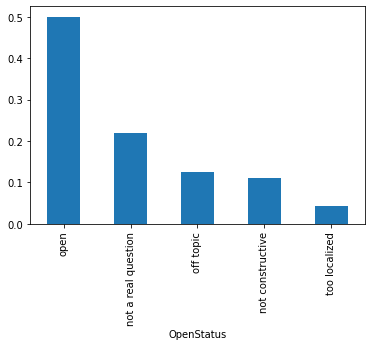

In [12]:
# Lets see the status events by %
stock_over_status_split = df_stock_over_raw.groupby(['OpenStatus']).count()['PostId']/140272
stock_over_status_split.sort_values(ascending=False).plot(kind="bar")
print('Question status %')

We see that about half is open in our sample.

In [13]:
# Lets see if we have more features with a small amount of values
df_stock_over_raw.nunique().sort_values()

OpenStatus                                  5
OwnerUndeletedAnswerCountAtPostTime       965
Tag1                                     5209
ReputationAtPostCreation                 6423
Tag5                                     7605
Tag2                                     9292
Tag4                                    10027
Tag3                                    11080
PostClosedDate                          70070
OwnerCreationDate                       94149
OwnerUserId                             94215
PostCreationDate                       140118
Title                                  140192
BodyMarkdown                           140270
PostId                                 140272
dtype: int64

In [14]:
# lets see the first 3 headers/body
for i in range(1):
    print('Question number {}: \n\nheader is: \n{}\nbody: \n{} \n'.format(i+1,df_stock_over_raw['Title'].iloc[i],df_stock_over_raw['BodyMarkdown'].iloc[i]))

Question number 1: 

header is: 
For Mongodb is it better to reference an object or use a natural String key?
body: 
I am building a corpus of indexed sentences in different languages. I have a collection of Languages which have both an ObjectId and the ISO code as a key. Is it better to use a reference to the Language collection or store a key like "en" or "fr"?

I suppose it's a compromise between:

 - ease of referencing the Language
 - object in that collection
 - speed in doing queries where the sentence has a certain language
 - the size of the data on disk

Any best practices that I should know of? 



### Lets take a look at the amount of words we have in the first 95% data points

In [15]:
full_text = df_stock_over_raw['Title'] + df_stock_over_raw['BodyMarkdown']
full_text_count = full_text.str.split().str.len()

<AxesSubplot:>

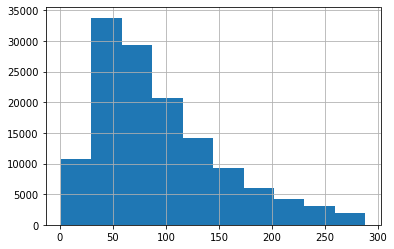

In [16]:
full_text_count[full_text_count<full_text_count.quantile(0.95)].hist(bins=10)

So we can easily see that most of our data is below BERT's 512 tolkens limit, thats good!

# 4. Data cleaning and preparation

In [11]:
# Lets start with creating a new column for combining head and body
df_stock_over_raw['text'] = df_stock_over_raw['Title'] + ' ' +df_stock_over_raw['BodyMarkdown']

In [12]:
# looks good!
df_stock_over_raw[0:1][['text','BodyMarkdown','Title']]

,text,BodyMarkdown,Title
0,"For Mongodb is it better to reference an object or use a natural String key? I am building a corpus of indexed sentences in different languages. I have a collection of Languages which have both an ObjectId and the ISO code as a key. Is it better to use a reference to the Language collection or store a key like ""en"" or ""fr""?\r\n\r\nI suppose it's a compromise between:\r\n\r\n - ease of referencing the Language\r\n - object in that collection\r\n - speed in doing queries where the sentence has a certain language\r\n - the size of the data on disk\r\n\r\nAny best practices that I should know of?","I am building a corpus of indexed sentences in different languages. I have a collection of Languages which have both an ObjectId and the ISO code as a key. Is it better to use a reference to the Language collection or store a key like ""en"" or ""fr""?\r\n\r\nI suppose it's a compromise between:\r\n\r\n - ease of referencing the Language\r\n - object in that collection\r\n - speed in doing queries where the sentence has a certain language\r\n - the size of the data on disk\r\n\r\nAny best practices that I should know of?",For Mongodb is it better to reference an object or use a natural String key?


In [13]:
# Lets create a new df with only the relavent columns
df_for_bert = df_stock_over_raw[['text','OpenStatus']]

In [14]:
# Lets change the names of our text and lables
df_for_bert.columns = ['text','label']
df_for_bert.columns

Index(['text', 'label'], dtype='object')

In [15]:
# mapping the category name to numbers

labels_status = {'open': 0, 
           'too localized': 1,
           'not a real question': 2,
           'off topic': 3,
           'not constructive':4}

df_for_bert['label'] = df_for_bert['label'].map(labels_status)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":


### Split train dataset into train, validation and test sets

In [17]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df_for_bert['text'], df_for_bert['label'], 
                                                                    random_state=42, 
                                                                    test_size=0.3, 
                                                                    stratify=df_for_bert['label'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=42, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

### Import BERT Model and BERT Tokenizer

In [18]:
# import BERT model
bert = BertModel.from_pretrained('bert-base-uncased')

# Loading the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

### Preparing the tokenizers

In [39]:
# setting the maximum tokens possible for BERT 512 or less if GPU space isnt sufficient
max_seq_len = 512

# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


### Casting type to torch tensor

In [40]:
# Train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_y = torch.tensor(train_labels.tolist())
train_mask = torch.tensor(tokens_train['attention_mask'])

# Validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_y = torch.tensor(val_labels.tolist())
val_mask = torch.tensor(tokens_val['attention_mask'])

# Test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_y = torch.tensor(test_labels.tolist())
test_mask = torch.tensor(tokens_test['attention_mask'])

### Creating DataLoaders

In [41]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# 5. Building our custom BERT model

### Class creation

In [42]:
'''
Class BERT_Arch is based on pre-trained model BERT, its designed to output five classes

'''

class BERT_Arch(nn.Module):

    def __init__(self, bert):
        
      
        super(BERT_Arch, self).__init__()

        self.bert = bert 
      
        # dropout layer
        self.dropout = nn.Dropout(0.1)
      
       # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768,512)
      
        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,5)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):
        

        #pass the inputs to the model  
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
        
        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        # output layer
        x = self.fc2(x)
      
        # apply softmax activation
        x = self.softmax(x)

        return x

### Instantiation the model and transfering to GPU mode

In [43]:
# specify GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)


# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


### Creating the train Class

In [24]:
'''
Function for train the model

Input:  None

Output: 
        avg_loss (Float) - the average loss
        total_preds (List) - List of model predictions
'''

# function to train the model
def train():
  
    model.train()

    total_loss, total_accuracy = 0, 0
  
    # empty list to save model predictions
    total_preds=[]
  
    # iterate over batches
    for step,batch in enumerate(train_dataloader):
    
        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        # push the batch to gpu
        batch = [r.to(device) for r in batch]
 
        sent_id, mask, labels = batch

        # clear previously calculated gradients 
        model.zero_grad()        

        # get model predictions for the current batch
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()
  
        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()

        # append the model predictions
        total_preds.append(preds)
    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)
  
    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds

### Creating the evaluate calss

In [25]:
'''
Function for evaluating the model

Input:  None

Output: 
        avg_loss (Float) - the average loss
        total_preds (List) - List of model predictions
'''

def evaluate():
    
    print("\nEvaluating...")
    
    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0
  
    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step,batch in enumerate(val_dataloader):
    
        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
    

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
        
        # model predictions
        preds = model(sent_id, mask)

        # compute the validation loss between actual and predicted values
        loss = cross_entropy(preds,labels)

        total_loss = total_loss + loss.item()

        preds = preds.detach().cpu().numpy()

        total_preds.append(preds)
    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader) 

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

# 6. Training

### Freeze BERT Parameters

In [22]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

### Setting up the loss function and number of epochs

In [26]:
# loss function
cross_entropy  = nn.NLLLoss() 

# number of training epochs
epochs = 3

### Training and tarning/validation losses

In [27]:
# set initial loss to infinite
best_valid_loss = float('inf')
model = model.to(device)

# lists for validation and traning loesses
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 3
  Batch    50  of  1,094.
  Batch   100  of  1,094.
  Batch   150  of  1,094.
  Batch   200  of  1,094.
  Batch   250  of  1,094.
  Batch   300  of  1,094.
  Batch   350  of  1,094.
  Batch   400  of  1,094.
  Batch   450  of  1,094.
  Batch   500  of  1,094.
  Batch   550  of  1,094.
  Batch   600  of  1,094.
  Batch   650  of  1,094.
  Batch   700  of  1,094.
  Batch   750  of  1,094.
  Batch   800  of  1,094.
  Batch   850  of  1,094.
  Batch   900  of  1,094.
  Batch   950  of  1,094.
  Batch 1,000  of  1,094.
  Batch 1,050  of  1,094.

Evaluating...
  Batch    50  of    235.
  Batch   100  of    235.
  Batch   150  of    235.
  Batch   200  of    235.

Training Loss: 1.341
Validation Loss: 0.006

 Epoch 2 / 3
  Batch    50  of  1,094.
  Batch   100  of  1,094.
  Batch   150  of  1,094.
  Batch   200  of  1,094.
  Batch   250  of  1,094.
  Batch   300  of  1,094.
  Batch   350  of  1,094.
  Batch   400  of  1,094.
  Batch   450  of  1,094.
  Batch   500  of  1,094.
  

# 7. Evaluate the model results

In [46]:
# Push the model to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

pred_list = []
county = 0


# Get predictions for test data, create a list of predictions to evaluate later
with torch.no_grad():
    model.eval()
    for s,m in zip(test_seq,test_mask):   
        county += 1
        preds = model(s.to(device).reshape(1,512), m.to(device).reshape(1,512))
        preds = preds.detach().cpu().numpy()
        
        if county==10000:
            print('10k')
        if county==20000:
            print('20k')
        
        pred_list.append(preds[0])

In [47]:
# Pick the higest score for prediction
pred_list = np.argmax(pred_list, axis = 1)

In [49]:
# model's performance
print(classification_report(test_y, pred_list))

              precision    recall  f1-score   support

           0       0.59      0.93      0.73      3748
           1       0.00      0.00      0.00       326
           2       0.51      0.33      0.40      1641
           3       0.50      0.12      0.20       947
           4       0.61      0.24      0.34       838

    accuracy                           0.58      7500
   macro avg       0.44      0.32      0.33      7500
weighted avg       0.54      0.58      0.51      7500



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:xlabel='Real value', ylabel='Predicted value'>

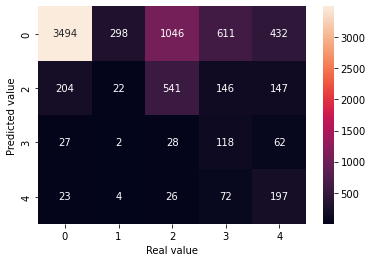

In [50]:
# confusion matrix

df_cm = pd.crosstab(pred_list,test_y,colnames=['Real value'], rownames=['Predicted value'])
sn.heatmap(df_cm, annot=True, fmt='.5g')

### Saving and loading the models

In [236]:
#save BERT
#torch.save(model.state_dict(),'model_state_v3.pth')

In [44]:
# load BERT
model = BERT_Arch(bert)
model.load_state_dict(torch.load('../input/model-state-v3/model_state_v1.pth'))

<All keys matched successfully>

# 8. Conclusions

I ran the training loop three times in order to get a better result. <br>
We can see the model definitely "learned" and gets a better score than random prediction.

I see two ways to use the model:

1. Approve any post that comes in and then take only the question that predicted anything that is not 0 (open question), then a human will take a look and decide if the question should be closed. In this case, we can get 12%-33% of type 2/3/4 questions denied and 0% of type 1. The rest will be falsy approved.
2. Approve type 0 prediction automatically, it will mean that we will lose 7% of good questions and give false approval to about 50% of type 2,3,4 of questions and 100% of type 1. This is the easiest way to implment the model, but will probely have to approve the results before.

I think I will keep training the model and maybe change the drop rate/model feature in order to improve my results, especially in category 1.